In this notebook, we'll examine the UCI electricity demand dataset (see [here][0]), and set up a dataframe that can be used for time series prediction testing. 

[0]:https://archive.ics.uci.edu/dataset/321/electricityloaddiagrams20112014

Note that this notebook is for documentation only, the model data can be updated by running `zero-time-series-demo prep --download-base-data --prep-base-data --prep-model-data`

# Inspect Data

In [1]:
from zero_ts_demo.imports import *
from zero_ts_demo.helpers import load_base_data
from zero_ts_demo import helpers as hp

First, we must have path `/home/zero/zero-ts-demo-data/LD2011_2014.csv.gz`, dataset can be downloaded and preparted by running `zero-time-series-demo prep --download-base-data --prep-base-data`. 

Then, we'll load the dataset into memory and retain the original dataframe as `BASE_DATA`:

In [2]:
BASE_DATA = load_base_data()

mem = float(BASE_DATA.memory_usage(deep=True).sum() / 1024**3)
print(f"uses {mem:.3f} gb in memory")
BASE_DATA.tail(5)

uses 0.388 gb in memory


,mt_001,mt_002,mt_003,mt_004,mt_005,mt_006,mt_007,mt_008,mt_009,mt_010,...,mt_361,mt_362,mt_363,mt_364,mt_365,mt_366,mt_367,mt_368,mt_369,mt_370
date,,,,,,,,,,,,,,,,,,,,,
2014-12-31 23:00:00,2.538071,22.048364,1.737619,150.406504,85.365854,303.571429,11.305822,282.828283,68.181818,72.043011,...,276.945039,28200.0,1616.033755,1363.636364,29.986962,5.851375,697.102722,176.961603,651.026393,7621.621622
2014-12-31 23:15:00,2.538071,21.337127,1.737619,166.666667,81.707317,324.404762,11.305822,252.525253,64.685315,72.043011,...,279.800143,28300.0,1569.620253,1340.909091,29.986962,9.947338,671.641791,168.614357,669.354839,6702.702703
2014-12-31 23:30:00,2.538071,20.625889,1.737619,162.601626,82.926829,318.452381,10.175240,242.424242,61.188811,74.193548,...,284.796574,27800.0,1556.962025,1318.181818,27.379400,9.362200,670.763828,153.589316,670.087977,6864.864865
2014-12-31 23:45:00,1.269036,21.337127,1.737619,166.666667,85.365854,285.714286,10.175240,225.589226,64.685315,72.043011,...,246.252677,28000.0,1443.037975,909.090909,26.075619,4.095963,664.618086,146.911519,646.627566,6540.540541
2015-01-01 00:00:00,2.538071,19.914651,1.737619,178.861789,84.146341,279.761905,10.175240,249.158249,62.937063,69.892473,...,188.436831,27800.0,1409.282700,954.545455,27.379400,4.095963,628.621598,131.886477,673.020528,7135.135135


We'll work with a copy of the base data:

In [3]:
# copy base data
df = BASE_DATA.copy().sort_index()

Let's plot some data:

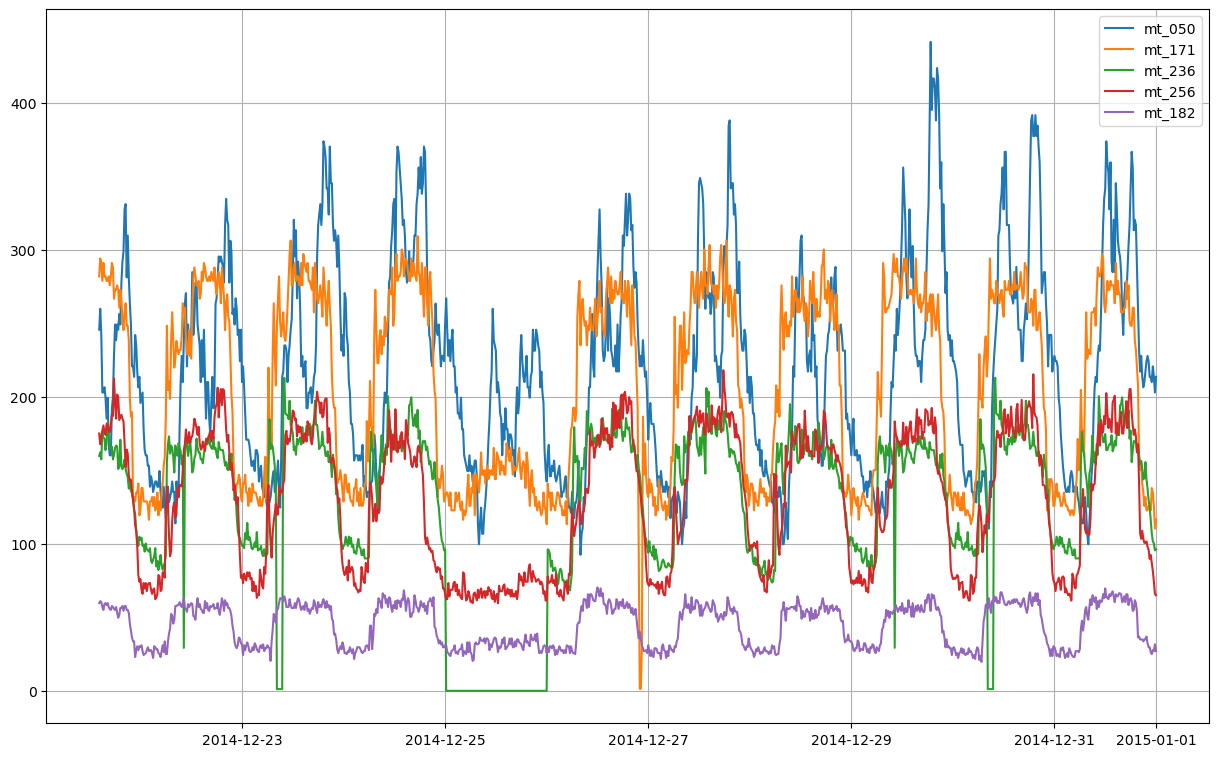

In [4]:
from matplotlib import pyplot as plt

random_state = 38383
# plot a sample of cols
cols = (pd.Series(df.select_dtypes(include='float').columns)
          .sample(5, random_state=random_state).tolist())

n_plot = 1000 # number of samples to plot
w = 15
FS = (w, w/1.618)
fig, ax = plt.subplots(figsize=FS)

for col in cols:
    ax.plot(df.tail(n_plot).index, df[col].tail(n_plot), label=col)
plt.legend()
plt.grid()
plt.show()

...noting that the above is a sample of 5 of the 370 values. 

There are too many time series here to realistically review all of them manually, but we don't want to proceed without some more inspection. 

One thing we can do is use a simple anamoly detection method. Basicall, we'll calculate a moving average for each time series, then calculate the z-score of the deviation from the moving average. This way, we can at least scan for observations that are significantly outside of a probabilistic expectation. 

Not all of the series start at the same time, so we'll have to calculate each independently. 

In [5]:
from zero_ts_demo import prep_model_data as pmd

hp.display_source(pmd.calculate_z)
hp.display_source(pmd.summarize_anamolies)

```python
def calculate_z(X):
    """Given a series of data, calculate z-score metrics"""
    x = X[X > 0].copy().rename('kw')
    m = x.rolling(8).mean().rename('kw_rolling_mean')
    sl = pd.concat([x, m], axis=1).dropna().sort_index()
    sl['z_score'] = ((sl['kw'] - sl['kw_rolling_mean']) / sl['kw'].std()).abs()
    return sl

```

```python
def summarize_anamolies(df):
    """Calculate maximum abs(z-score) for each column"""
    z_scores = dict()
    for col in df.columns:
        sl = calculate_z(df[col])
        z_scores[col] = sl['z_score'].max()
    return pd.Series(z_scores).sort_values()

```

Now we can create a `Series` called `zs`, and we can see that there are many series that have z-scores that are extreme:

In [6]:
zs = pmd.summarize_anamolies(df)
zs.tail(10)

mt_147     9.195486
mt_149     9.206351
mt_146    10.021066
mt_003    10.034736
mt_145    10.724390
mt_133    10.770402
mt_148    11.380473
mt_131    11.501237
mt_002    12.955151
mt_347    15.858856
dtype: float64

For `mt_347`, there are some periods of time that have spikes in energy consumption that are full orders of magnitude different than nearby values:

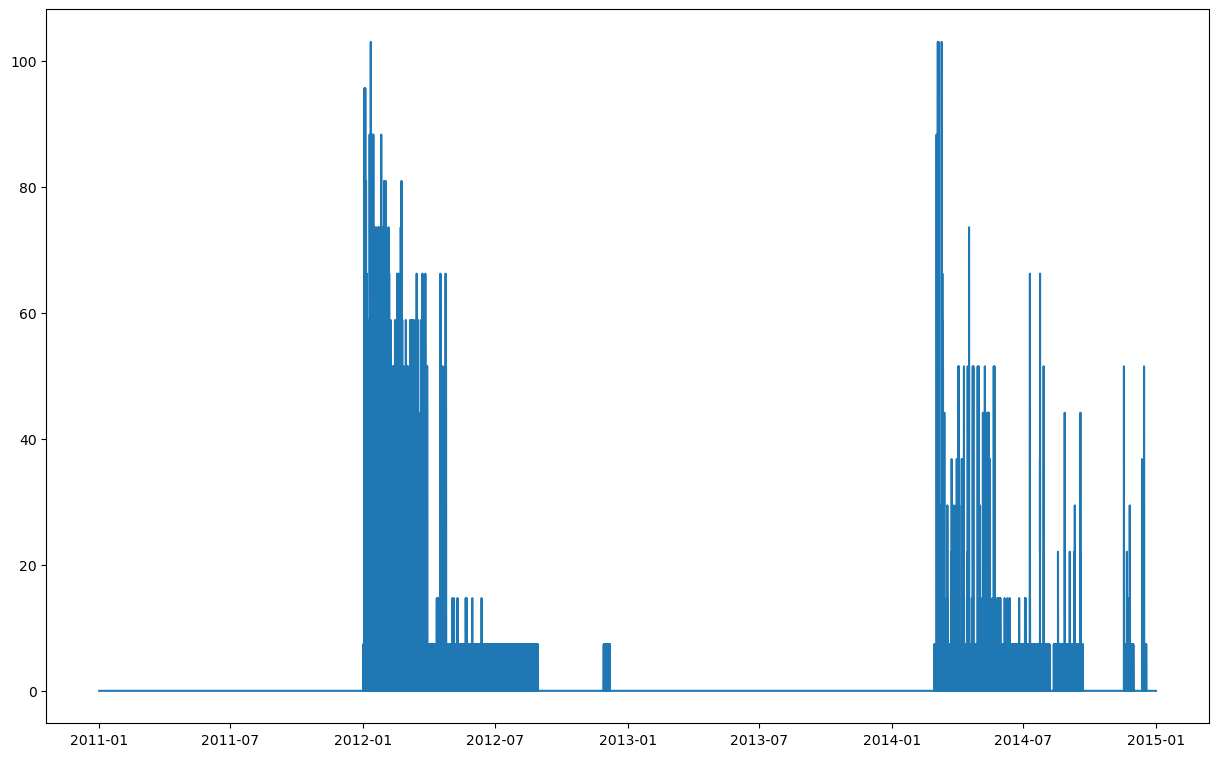

In [7]:
fig, ax = plt.subplots(figsize=FS)
ax.plot(df.index, df['mt_347'])
plt.show()

In real world-application, we couldn't simply ignore these series. However, the goal of this project is to demonstrate time series forecasting methods, and dealing with such extreme variation in magnitude is a challenge in and of itself. 

Therefore, we'll first attempt to predict the time series which are relatively well-behaved, so let's subset our data for those that are:

In [8]:
hp.display_source(pmd.subset_data)
n = BASE_DATA.shape[1]
df = pmd.subset_data(BASE_DATA.copy())
print(f"* dropped {n-df.shape[1]:.0f} columns out of {n} from df. ")
print(df.shape)

```python
def subset_data(df):
    """Select only time series with ceiling z-score"""
    zs = summarize_anamolies(df)
    cols = zs[zs < 4].index.tolist()
    return df[cols].copy()

```

* dropped 62 columns out of 370 from df. 
(140256, 308)


Now we can proceed by analyzing these well-behaved time series data. In future iterations we can tackle the much-harder cases of the time series with massive anamolies.